In [12]:
from cem_optimizer_v2 import CEM_opt
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from queue import Queue
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import torch


In [13]:
env_name = 'plate-slide-side-v2-goal-observable'
env_cls = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[env_name]
env_planner = env_cls()
env_test = env_cls()

env_action_space_shape = env_test.action_space.shape[0]
env_obs_space_shape = env_test.observation_space.shape[0]

/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [43]:
class InformedPlanner:
    
    def __init__(self, env):
        
        self.env = env
        self.horizon = 20
        self.num_sequence_action = 100
        self.cem = CEM_opt(num_action_seq=self.num_sequence_action,
                           action_seq_len=env_action_space_shape * self.horizon,
                           percent_elite=0.1)
        self.action_seq_planned = Queue(maxsize=self.horizon)
        
        
    def plan(self, force_replan=False):
        
        if self.action_seq_planned.empty() or force_replan:
            
            action_sequences = self.cem.population
            rewards = np.zeros(action_sequences.shape[0])
            for idx, seq in enumerate(action_sequences):
                rewards[idx] = self.eval_act_seq(seq)
            self.cem.update(rewards)
            
            for act in self.cem.solutions().reshape(-1, 4):
                self.action_seq_planned.put(act)
        return self.action_seq_planned.get()
            
            
                    
    def eval_act_seq(self, sequence):
        rew_seq = 0
        self.env.reset()
        act_reshaped = sequence.reshape((-1, 4))
        for act in act_reshaped:
            
            _, r, _, _ = self.env.step(act)
            rew_seq += r
        return rew_seq/len(sequence)

planner = InformedPlanner(env_planner)
planner.plan()

array([-0.03647775, -0.01997196, -0.52366745, -0.16447898])

In [44]:
planner = InformedPlanner(env_planner)

TOT_avg_rew = []
TOT_avg_rew.append(0)
TOT_avg_rew.append(0)

for ep in range(100):
    
    env_test.reset()

    r_for_ep = 0
    for h in range(100):
        act = planner.plan()
        s_prime, r, done, _ = env_test.step(act)
        r_for_ep += r
        if r==10.0:
            done= True
            print(f"SOLVED IN {ep} iteration")
            break 
        print(f'episode {ep}, step {h}, reward  {r} | done? {done}')
    if done == True: break
    
    TOT_avg_rew.append(r_for_ep)
    print(f'prev avg rew {TOT_avg_rew[-2]}, actual avg rew {TOT_avg_rew[-1]}')
    clear_output(wait=True)

        

episode 38, step 0, reward  0.20408052908578422 | done? False
episode 38, step 1, reward  0.21453087533026677 | done? False
episode 38, step 2, reward  0.23316362729378026 | done? False
episode 38, step 3, reward  0.26203325867269145 | done? False
episode 38, step 4, reward  0.3041059671819527 | done? False
episode 38, step 5, reward  0.3629786832743111 | done? False
episode 38, step 6, reward  0.44409461522095384 | done? False
episode 38, step 7, reward  0.5561838940898571 | done? False
episode 38, step 8, reward  0.7081194806270169 | done? False
episode 38, step 9, reward  0.8926291320165323 | done? False
episode 38, step 10, reward  1.0876131185610094 | done? False
episode 38, step 11, reward  1.2723386729602162 | done? False
episode 38, step 12, reward  1.4197175595938987 | done? False
episode 38, step 13, reward  1.4965984925749818 | done? False
episode 38, step 14, reward  1.5 | done? False
episode 38, step 15, reward  1.5 | done? False
episode 38, step 16, reward  1.5 | done? Fa

KeyboardInterrupt: 

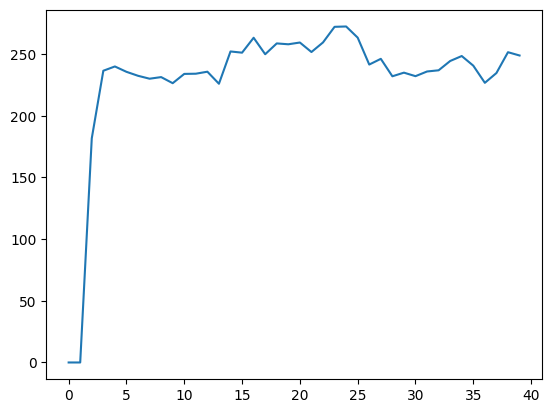

In [45]:
plt.plot(TOT_avg_rew)

In [6]:
planner = InformedPlanner(env_planner)

acts_to_exec = planner.plan()
acts_to_exec = acts_to_exec.reshape((-1, 4))

In [8]:
import time

In [9]:
env_test.reset()

for idx, a in enumerate(acts_to_exec):
    if idx == 0:
        time.sleep(0.1)
    time.sleep(0.005)
    env_test.render()
    env_test.step(a)
env_test.close()

Creating window glfw
